In [26]:
import scanpy as sc
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80, facecolor='white', frameon=False
)

We first load the preprocessed and clustered anndata object into our notebook. 

In [32]:
adata = sc.read('s4d8_subset_gex_pp.h5ad')

# Mannual annotation

Manual annotation describes the process of studying genes and merkers specific to each identified cluster in the dataset. Even if your dataset is annotated with automatic cell type annotation methods or via query-to-reference mapping, it is still crucial to understand the basic functionalities of manual annotation to verify automatic cell annotations and potentially identify novel cell types and states {cite}`Clarke2021-fj`.

In manual annotation, cell types are typically inferred on cluster level by using lists of marker genes, pathway analysis and differentially expressed genes. Lists of marker genes are typically derived from literature or databases. These lists contain known markers per cell type that are likely expressed in a cluster in the dataset that we want to annotate.

Even-though mannual annotation is a slow, labor intensive and relatively subjective task, it is still considered the gold-standard {cite}`Clarke2021-fj` fir cell type annotation. 



In [33]:
marker_genes = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'S100A9', 'CLEC12A', 'KLF4', 'PLAUR'],
    'cDC1': ['CLEC9A', 'CADM1'],
    'cDC2': ['CST3', 'COTL1', 'LYZ', 'DMXL2','CLEC10A', 'FCER1A'], # Note: DMXL2 should be negative
    'Normoblast': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers
    'NK': ['GNLY', 'NKG7', 'CD247', 'GRIK4', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'],
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT','IGLL1'],
    'Naive CD20+ B': ['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM'],
    'B1 B': ['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 'PRDM1', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM','ZNF215'], # Note IGHD and IGHM are negative markers
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cells': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'Plasmablast': ['XBP1', 'RF4', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
    'CD8+ T': ['CD8A','CD8B', 'GZMK','GZMA', 'CCL5', 'GZMB', 'GZMH', 'GZMA'],
    'T activation': ['CD69', 'CD38'], # CD69 much better marker!
    'T naive': ['LEF1', 'CCR7', 'TCF7'],
    'pDC': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R'],
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'NKAIN2','CD34'],
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'RYR3', 'PLCB1'] # Note PLCB1 is a negative marker
}


## Manual annotation
* rank genes based on leiden clustering

In [38]:
sc.tl.rank_genes_groups(adata, groupby='leiden_res1', key_added='rank_genes')

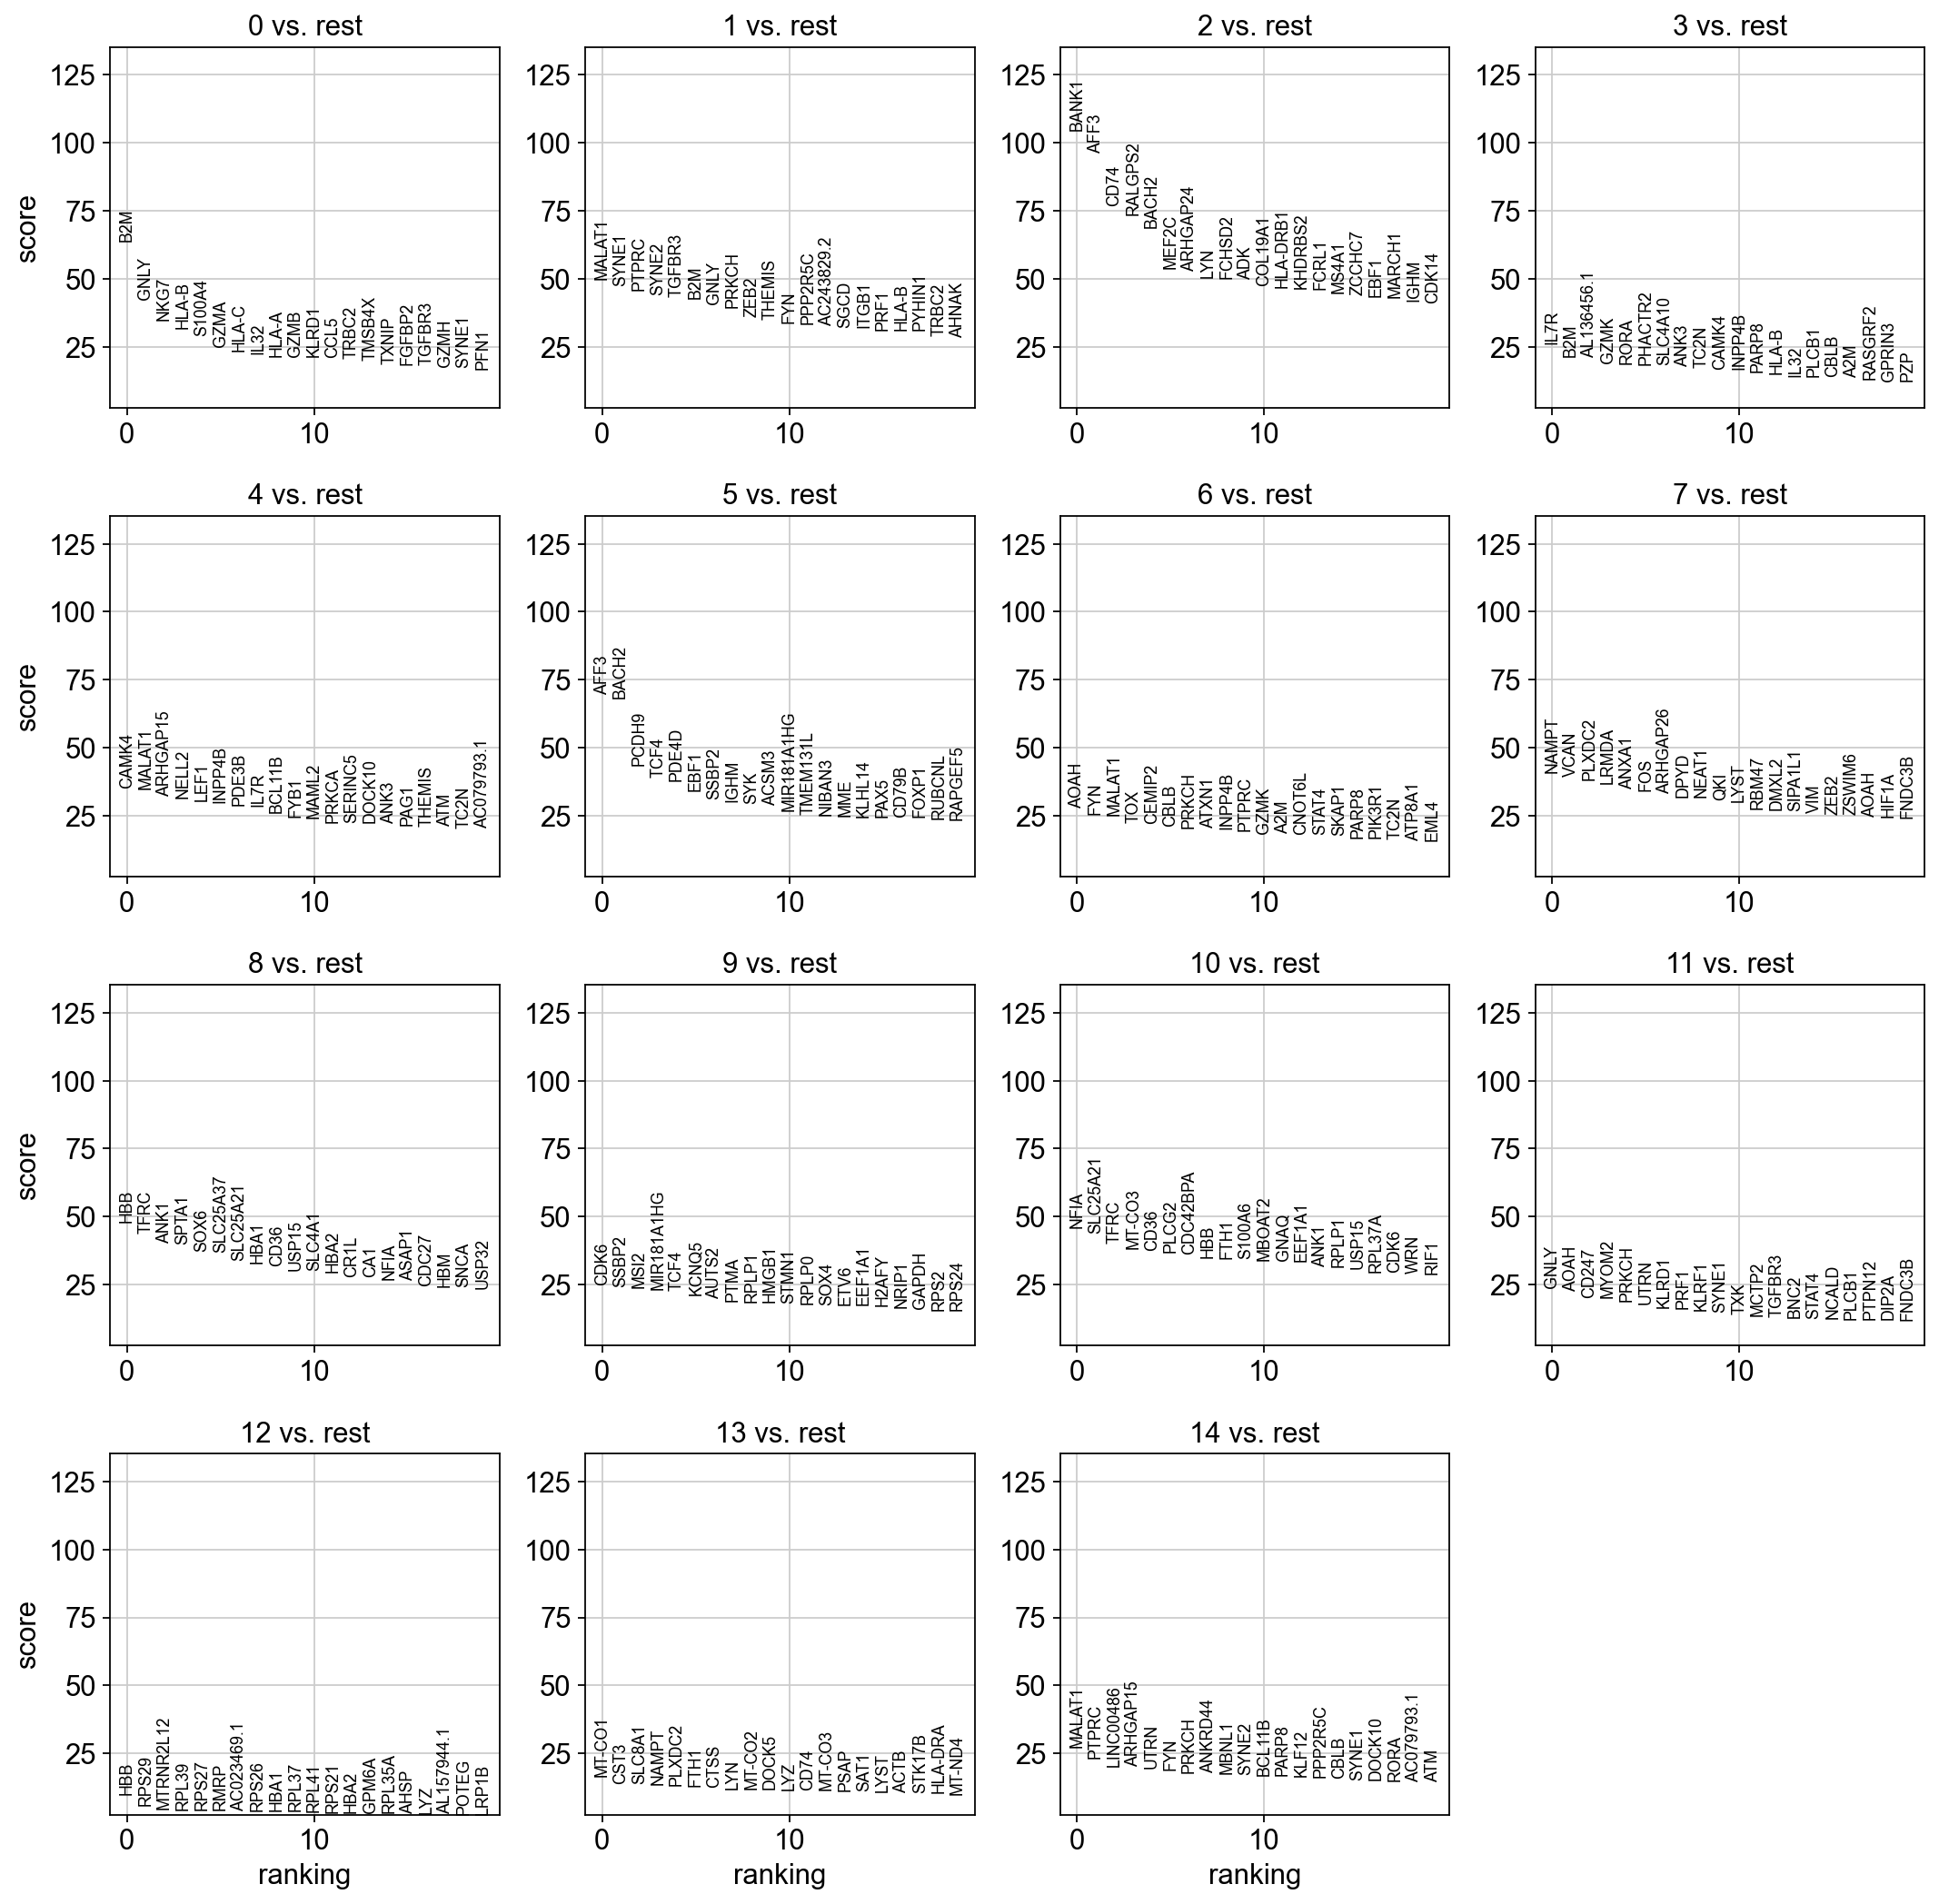

In [39]:
sc.pl.rank_genes_groups(adata, key='rank_genes')

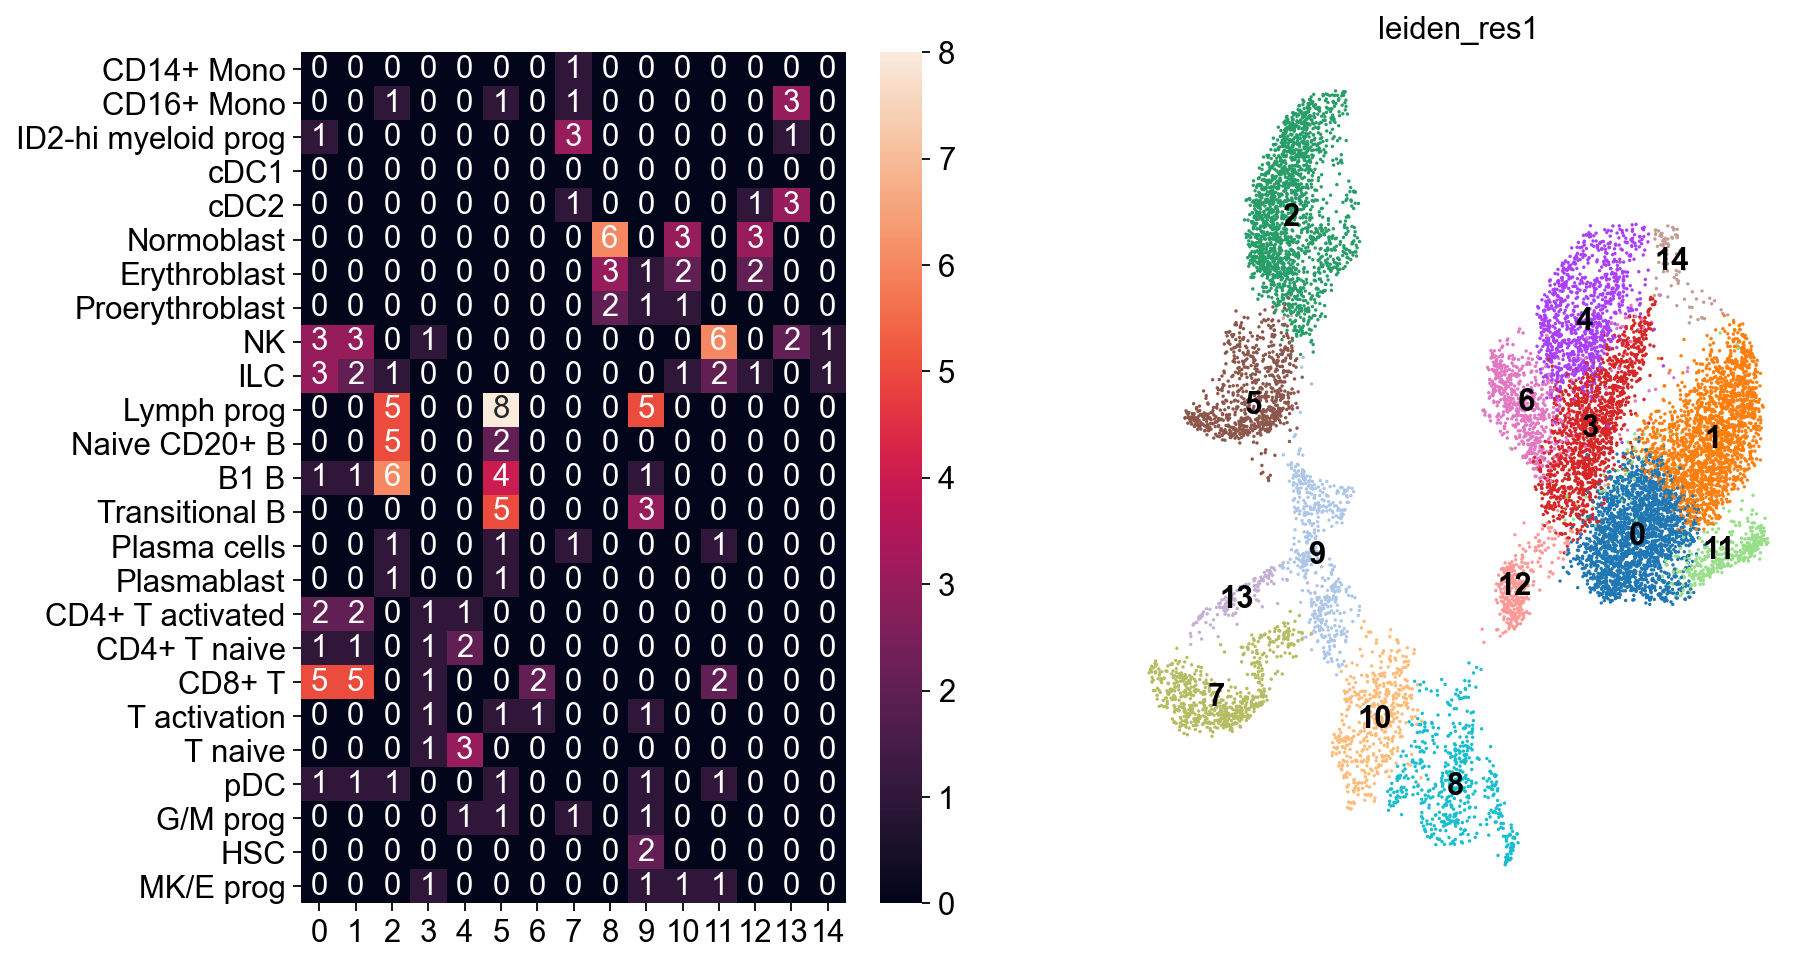

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(12,7))
sns.heatmap(sc.tl.marker_gene_overlap(adata, reference_markers=marker_genes, key='rank_genes'), ax=ax[0], annot=True)
sc.pl.umap(adata, color='leiden_res1', legend_loc='on data', ax=ax[1])
plt.show()

* assign cell types to clusters based on initial clustering and check if clusters clearly separate

First overview of clusters suggests:

* 0: NK, ILC, CD8+ T
* 1: Lymph prog., B cells
* 2: CD8+ T 
* 3: T naive
* 4: NK, ILC, CD8+ T
* 5: Erythrocyte development
* 6: Lymph prog., B cells
* 7: Monocytes, ID2-hi myeloid prog., cDC2
* 8: Lymph prog., B cells
* 9: HSC, MK/E prog
* 10: CD8+ T 
* 11: Erythrocyte development

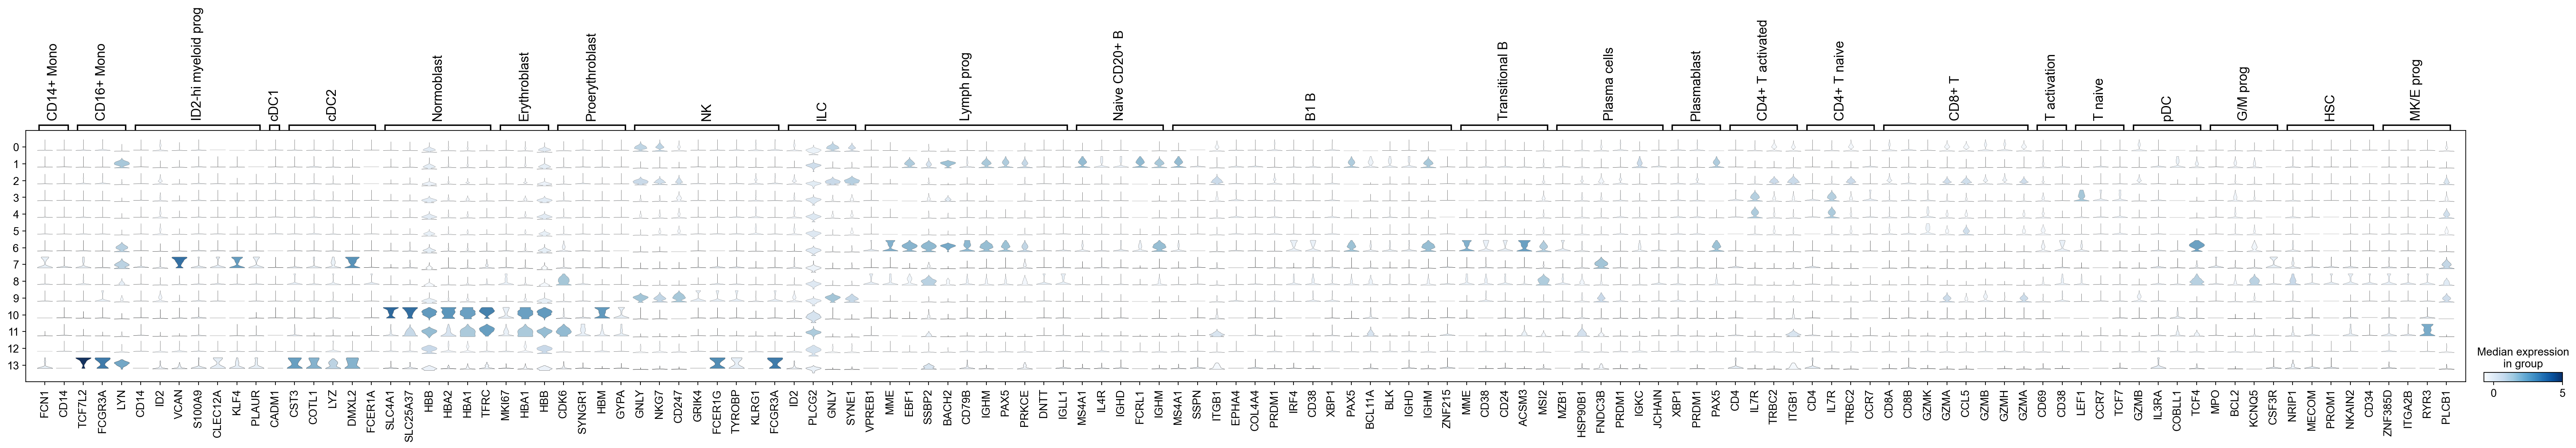

In [23]:
# Look at the marker genes in a concise manner
filt_marker_genes = dict()
for key,val in marker_genes.items():
    filt_vals = [i for i in val if i in adata.var_names]
    filt_marker_genes[key] = filt_vals

adata_plot = adata.copy()
sc.pp.scale(adata_plot, max_value=5)
    
sc.pl.stacked_violin(adata_plot, var_names = filt_marker_genes, groupby='leiden_res1.', use_raw=False, swap_axes=False)

Marker genes suggest:

* 0, 2, 10: CD8+ T

additionally 
* 3: CD8+ T (bottom), CD4+ T activated (middle), CD4+ T naive (top)


todo remove later:
* 1: Naive CD20+ B (left), B1B (right)

* 4: NK (bottom), CD8+ T (top)
* 5: Erythrocyte development
* 6: Lymph prog., B cells
* 7: Monocytes, ID2-hi myeloid prog., cDC2
* 8: Lymph prog., B cells
* 9: HSC, MK/E prog
* 11: Erythrocyte development

In [41]:
#adata.obs['grouped_leiden'] = [
#    '0' if c in ['0', '2', '10'] else c for c in adata.obs['leiden_res1.']
#]
#adata.obs['grouped_leiden'] = ['1' if c in ['1', '6', '8'] else c for c in adata.obs['grouped_leiden']]
#adata.obs['grouped_leiden'] = ['5' if c in ['5', '11'] else c for c in adata.obs['grouped_leiden']]

#adata.obs['grouped_leiden'] = adata.obs['grouped_leiden'].astype('category')
#adata.obs['grouped_leiden'].value_counts()

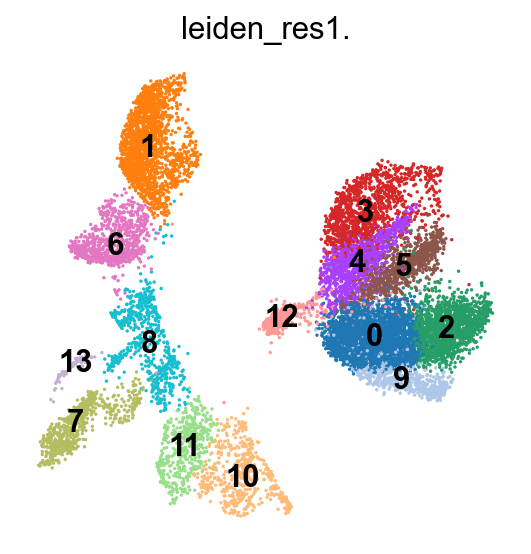

In [24]:
sc.pl.umap(adata, color='leiden_res1.', legend_loc='on data',)

### Subclustering 

* subclustering of not unclear clusters at different resolution

* same process as before with ranking of genes in new clusters

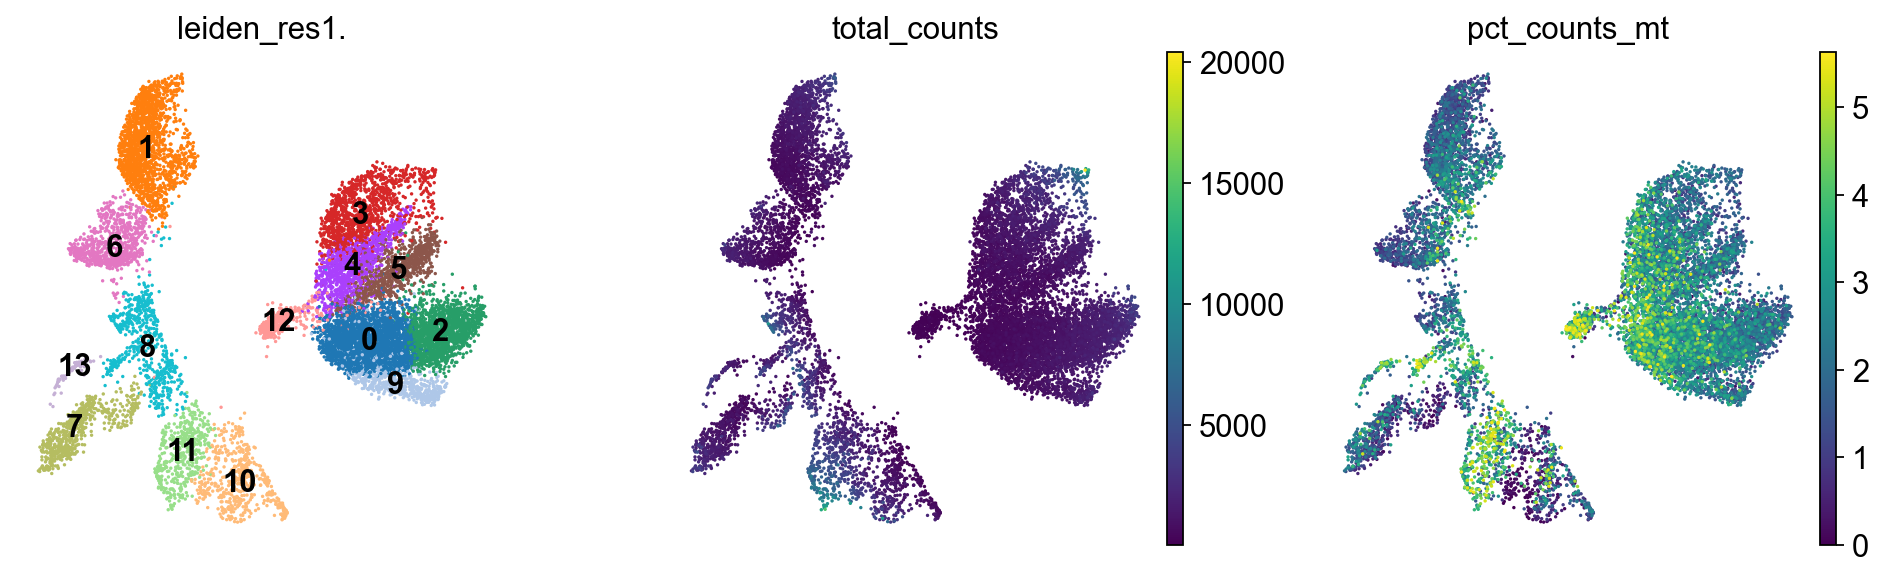

In [25]:
sc.pl.umap(adata, color=['leiden_res1.', 'total_counts', 'pct_counts_mt'], legend_loc='on data',)

### Cluster 1 - B cells

In [47]:
orig_key='leiden_res1.'
new_key = 'leiden_bsub'
new_rank_genes_key = 'rg_bsub'
sub_key = '2'

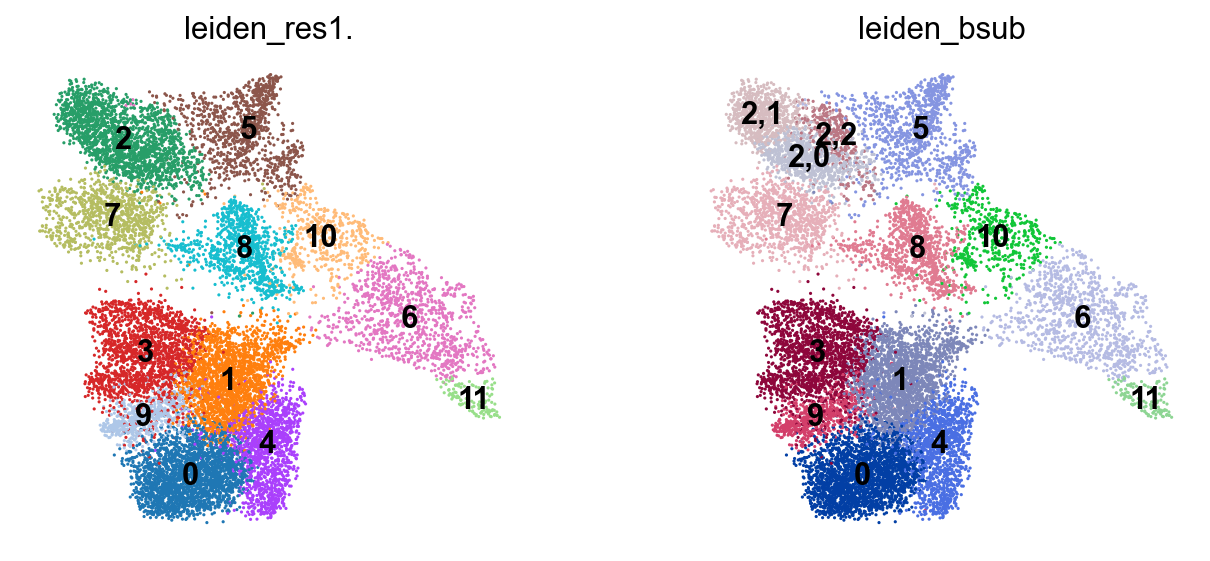

In [50]:
sc.tl.leiden(adata, restrict_to=(orig_key, [sub_key]), key_added=new_key, resolution=0.5)
sc.pl.umap(adata, color=[orig_key, new_key], legend_loc='on data')

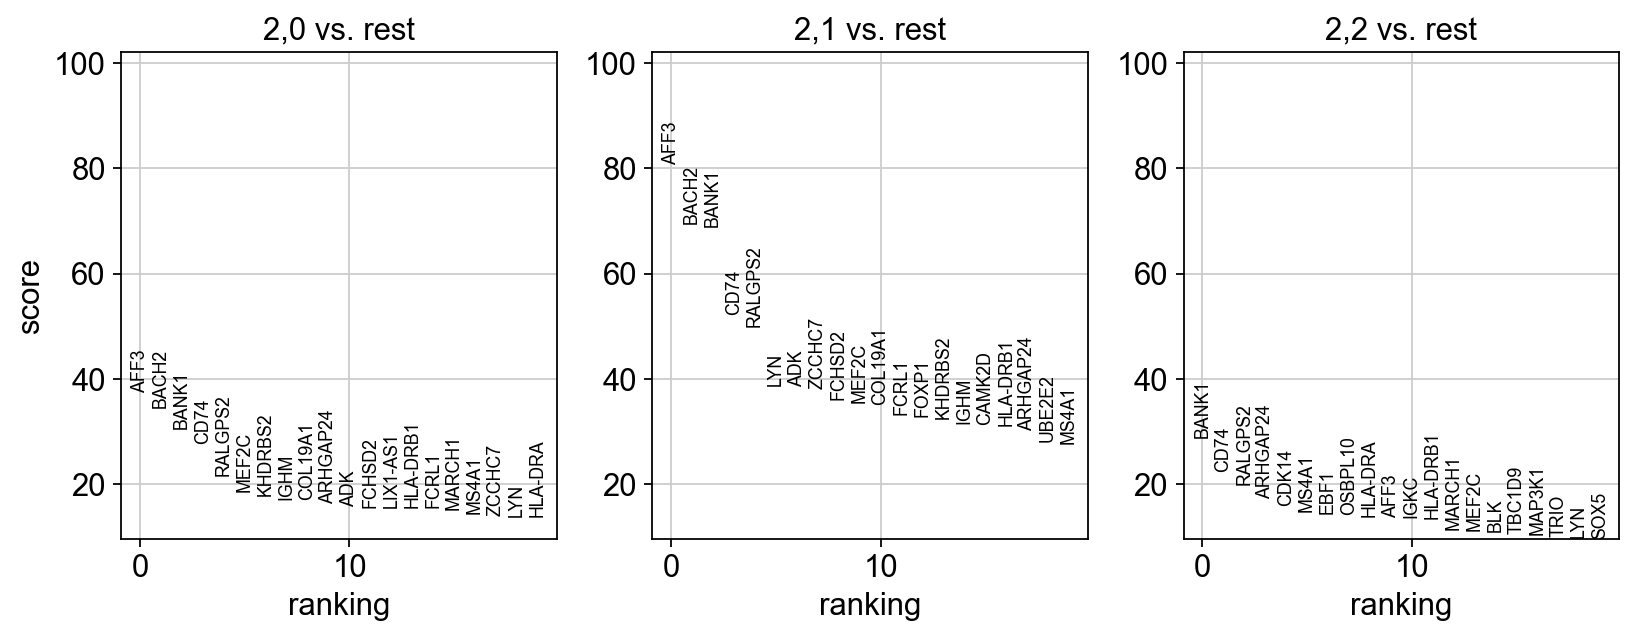

In [51]:
# Find markers of subclusters
num_subclusts = 3
new_groups = [f"{sub_key},{str(i)}" for i in range(num_subclusts)]
sc.tl.rank_genes_groups(adata, groupby=new_key, key_added=new_rank_genes_key, groups=new_groups)
sc.pl.rank_genes_groups(adata, key=new_rank_genes_key, groups=new_groups)

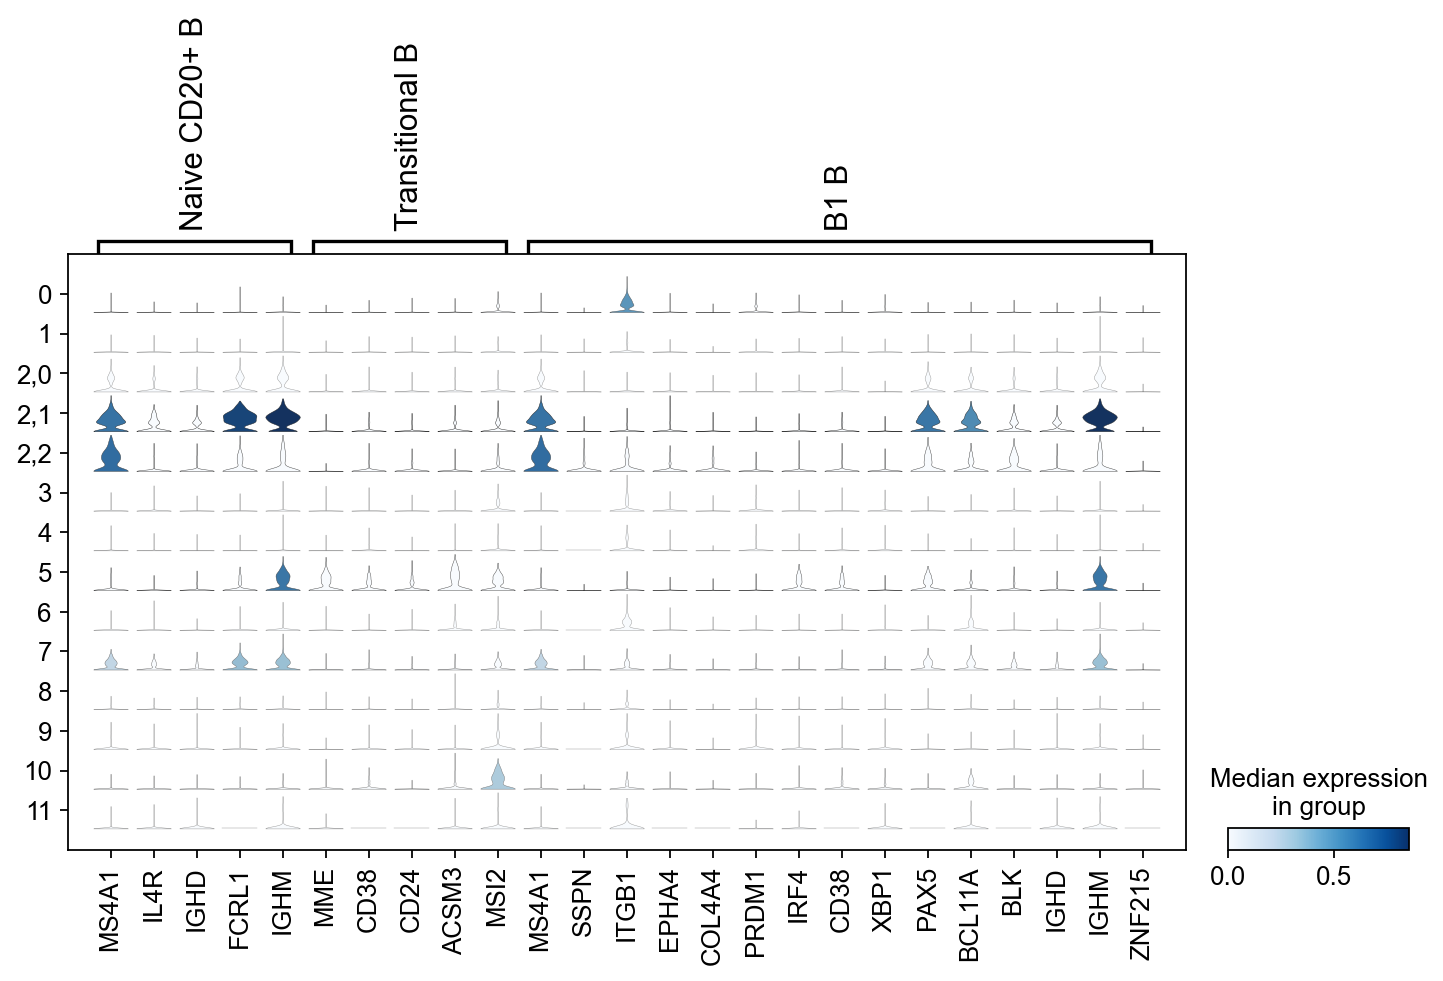

In [52]:
sc.pl.stacked_violin(
    adata, var_names={a:marker_genes[a] for a in ['Naive CD20+ B','Transitional B', 'B1 B']}, groupby=new_key
)

* 1,0 & 1,1 & 1,2: Naive CD20+ B
* 1,3 & 1,5: Transitional B
* 1,4 : B1 B
* 1,6: doublets

### Cluster 5 - Erythrocyte development

In [67]:
orig_key='grouped_leiden_bsub'
new_key = 'grouped_leiden_msub'
new_rank_genes_key = 'rg_msub'
sub_key = '7'

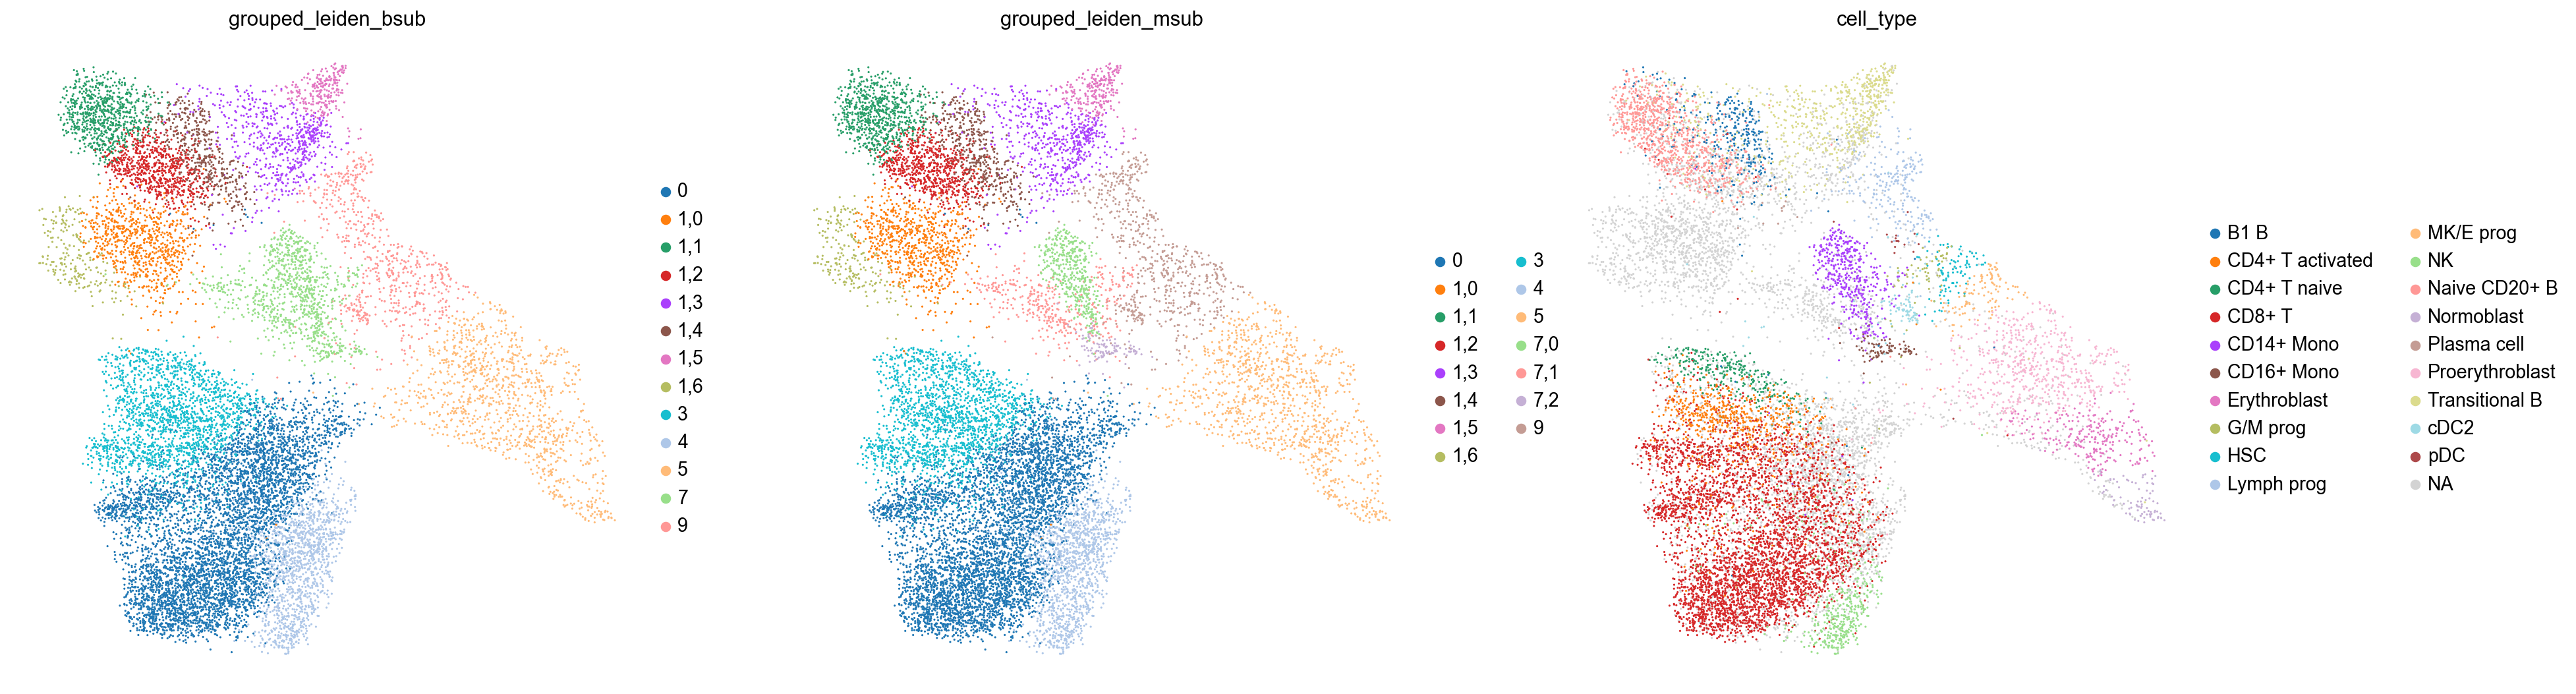

In [68]:
sc.tl.leiden(adata, restrict_to=(orig_key, [sub_key]), key_added=new_key, resolution=.3)
sc.pl.umap(adata, color=[orig_key, new_key, 'cell_type'])

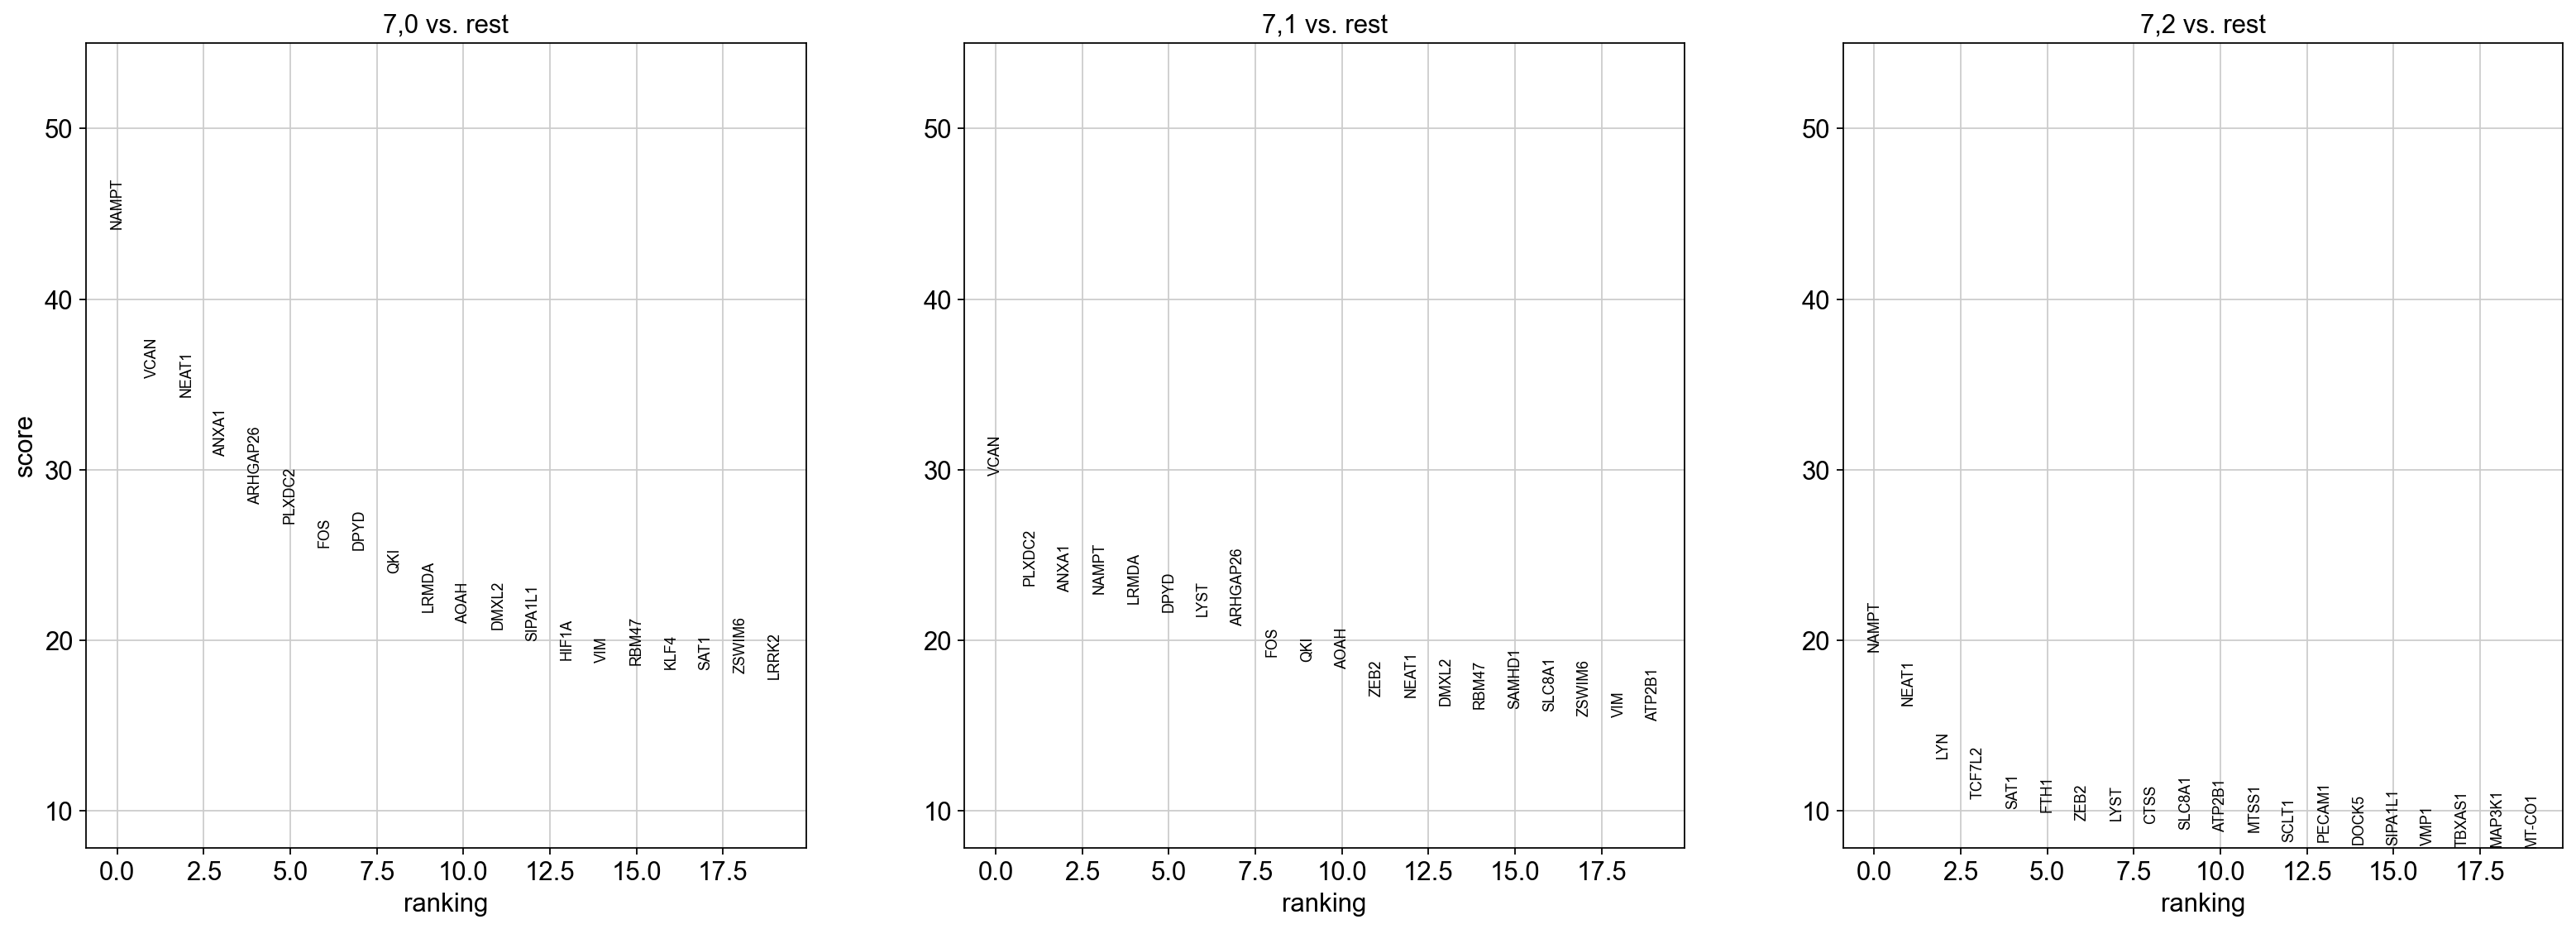

In [69]:
# Find markers of subclusters
num_subclusts = 3
new_groups = [f"{sub_key},{str(i)}" for i in range(num_subclusts)]
sc.tl.rank_genes_groups(adata, groupby=new_key, key_added=new_rank_genes_key, groups=new_groups)
sc.pl.rank_genes_groups(adata, key=new_rank_genes_key, groups=new_groups)

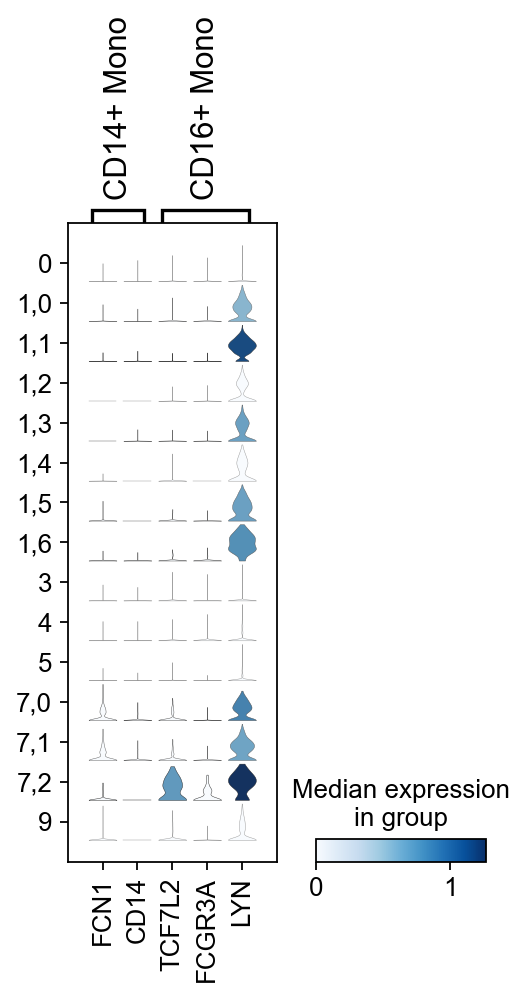

In [70]:
sc.pl.stacked_violin(
    adata, var_names={a:marker_genes[a] for a in ['CD14+ Mono','CD16+ Mono']}, groupby=new_key
)

* 7,0 & 7,1 : CD14+ Mono
* 7,2 : CD16+ Mono

* conclude with repetitive process until all cell types and sub types are identified
* potentially exclude cells that are not clearly identifiable based on list of marker genes and go back to preprocessing step with stricter thresholds for QC or higher percentage of doublet rate in dataset